In [187]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint, loguniform


In [188]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [189]:
dfs = []
for f in Path("data").iterdir():
    df = pd.read_csv(f)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [190]:
df = df[df["games_played"] == 82] 

In [191]:
df.shape

(2110, 109)

In [192]:
int_cols = df.select_dtypes(include="int64").columns.tolist()
int_cols

['season', 'games_played']

In [193]:
obj_cols = df.select_dtypes(include="object").columns.tolist()
obj_cols

['team', 'name', 'team.1', 'position', 'situation']

In [194]:
columns_to_drop = int_cols + obj_cols

In [195]:
df_pts = pd.read_csv("lol.csv")
df_pts.head()

,team,season,playoff
0,NYI,2009,0
1,ANA,2009,0
2,CGY,2009,0
3,EDM,2009,0
4,CBJ,2009,0


In [196]:
df = df.merge(
    df_pts, 
    on=["team", "season"],
    how="left"
)

In [197]:
missing_col = df.columns[df.isna().any()].tolist()
missing_col

['penaltiesFor', 'penaltiesAgainst', 'penalitiesFor', 'penalitiesAgainst']

In [198]:
columns_to_drop += missing_col
columns_to_drop

['season',
 'games_played',
 'team',
 'name',
 'team.1',
 'position',
 'situation',
 'penaltiesFor',
 'penaltiesAgainst',
 'penalitiesFor',
 'penalitiesAgainst']

In [199]:
df = df[df["situation"] == "all"] 

In [200]:
df = df.drop(columns=columns_to_drop)
df.head()

,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoff
1,0.50,0.48,0.49,300913.0,2466.97,238.16,172.96,545.72,81.21,1348.68,1056.27,228.49,238.01,228.35,2494.0,949.0,1182.0,4625.0,214.0,201.0,38.0,577.0,74.0,1047.0,1330.0,2280.0,3229.0,858.0,2261.0,1829.0,948.0,809.0,2521.0,684.0,238.0,74.34,82.03,81.79,79.0,65.0,70.0,4610.42,3443.0,3439.86,407.0,38.45,45.78,47.23,229.38,229.45,223.40,2578.49,242.24,181.31,573.57,84.06,1446.29,1110.53,231.91,243.26,232.90,2619.0,1019.0,1379.0,5017.0,258.0,166.0,41.0,660.0,99.0,1161.0,1294.0,2361.0,3380.0,919.0,2426.0,1872.0,833.0,826.0,2678.0,736.0,224.0,78.52,87.20,76.53,92.0,84.0,82.0,5040.57,3638.0,3650.78,398.0,40.28,38.07,40.25,242.28,243.11,235.81,0
6,0.46,0.48,0.47,299752.0,2342.95,218.89,161.52,513.90,75.09,1313.28,1009.26,211.93,219.20,212.23,2471.0,949.0,941.0,4361.0,233.0,162.0,43.0,530.0,68.0,1081.0,1346.0,2238.0,3187.0,1187.0,2187.0,2050.0,447.0,633.0,2624.0,625.0,171.0,83.32,75.26,60.31,82.0,80.0,71.0,4374.69,3420.0,3423.45,276.0,36.01,31.55,31.89,214.60,215.12,210.31,2622.30,259.16,182.73,577.49,86.50,1488.61,1088.63,243.45,259.47,243.73,2737.0,1091.0,943.0,4771.0,243.0,203.0,39.0,551.0,73.0,1266.0,1492.0,2494.0,3585.0,1123.0,2363.0,1763.0,548.0,661.0,2887.0,717.0,224.0,92.36,85.79,81.00,89.0,76.0,78.0,4761.74,3828.0,3822.06,326.0,40.81,45.50,47.18,243.46,243.09,235.24,0
11,0.50,0.51,0.50,298794.0,2379.63,201.14,156.39,544.08,75.75,1331.73,1013.27,194.96,202.33,196.15,2351.0,1005.0,1216.0,4572.0,201.0,133.0,31.0,529.0,66.0,1023.0,1404.0,2150.0,3155.0,1079.0,2237.0,1708.0,580.0,724.0,2666.0,507.0,183.0,73.96,62.47,64.70,80.0,57.0,64.0,4596.88,3356.0,3375.81,387.0,34.31,30.75,32.21,200.95,201.88,197.52,2344.66,203.81,158.95,533.19,76.85,1330.33,994.68,195.86,203.29,195.33,2372.0,966.0,1062.0,4400.0,203.0,160.0,43.0,506.0,77.0,1088.0,1304.0,2169.0,3135.0,1007.0,2424.0,1609.0,544.0,732.0,2605.0,555.0,178.

In [201]:
df.to_csv("starting_data.csv", index=False)

In [202]:
train_df, test_df = train_test_split(df)

In [203]:
models = {
    "decision_tree": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier(),
    "rbf_svm": SVC(),
    "lr": LogisticRegression(max_iter=1000)
}

In [204]:
results = {}

for name, model in models.items():
    cv = cross_validate(model, train_df.drop(columns="playoff"), train_df["playoff"], return_train_score=True)
    
    result_dict = {}
    result_dict["train_mean"] = cv["train_score"].mean()
    for i, score in enumerate(cv["train_score"]):
        result_dict[f"train_fold{i+1}"] = score
    
    result_dict["test_mean"] = cv["test_score"].mean()
    
    for i, score in enumerate(cv["test_score"]):
        result_dict[f"test_fold{i+1}"] = score
    
    results[name] = result_dict
    
results_df = pd.DataFrame(results).T
results_df.sort_values("test_mean", ascending=False)

c:\Users\ryanh\code\tests\nhl-test-2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ryanh\code\tests\nhl-test-2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/m

,train_mean,train_fold1,train_fold2,train_fold3,train_fold4,train_fold5,test_mean,test_fold1,test_fold2,test_fold3,test_fold4,test_fold5
lr,0.939880,0.948413,0.940711,0.960474,0.932806,0.916996,0.873413,0.875000,0.873016,0.841270,0.825397,0.952381
decision_tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.835615,0.781250,0.888889,0.841270,0.793651,0.873016
knn,0.752384,0.765873,0.743083,0.739130,0.758893,0.754941,0.667907,0.609375,0.650794,0.777778,0.666667,0.634921
rbf_svm,0.522153,0.523810,0.521739,0.521739,0.521739,0.521739,0.522173,0.515625,0.523810,0.523810,0.523810,0.523810


In [205]:
initial_test = LogisticRegression(max_iter=1000)
initial_test.fit(train_df.drop(columns="playoff"), train_df["playoff"])
initial_test.score(test_df.drop(columns="playoff"), test_df["playoff"])

c:\Users\ryanh\code\tests\nhl-test-2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8773584905660378

In [ ]:
# uncomment to see graphs that explain feature choices below
# fig, axes = plt.subplots(nrows=len(train_df.columns.tolist()), ncols=1, figsize=(10, 3*len(train_df.columns.tolist())))

# for i, c in enumerate(train_df.columns.tolist()):
#     train_df.groupby("playoff")[c].plot.hist(
#         bins=50,
#         alpha=0.5, 
#         legend=True, 
#         density=True, 
#         ax=axes[i]
#     )
    
#     axes[i].set_title(f"Histogram of {c}")
#     axes[i].set_xlabel(c)

# plt.tight_layout()
# plt.show()

In [207]:
v2_cols_to_del = ["iceTime",
                   "reboundsFor",
                   "reboundGoalsFor",
                   "playStoppedFor",
                   "playContinuedOutsideZoneFor",
                   "penalityMinutesFor",
                   "faceOffsWonFor",
                   "hitsFor",
                   "takeawaysFor",
                   "giveawaysFor",
                   "highDangerShotsFor",
                   "highDangerxGoalsFor",
                   "dZoneGiveawaysFor",
                   "xGoalsFromActualReboundsOfShotsFor",
                   "reboundxGoalsFor",
                   "blockedShotAttemptsAgainst",
                   "reboundsAgainst",
                   "reboundGoalsAgainst",
                   "freezeAgainst",
                   "playStoppedAgainst",
                   "penalityMinutesAgainst",
                   "faceOffsWonAgainst",
                   "hitsAgainst",
		           "takeawaysAgainst",
                   "giveawaysAgainst",
                   "highDangerShotsAgainst",
                   "highDangerxGoalsAgainst",
                   "dZoneGiveawaysAgainst",
                   "xGoalsFromxReboundsOfShotsAgainst",
                   "xGoalsFromActualReboundsOfShotsAgainst",
                   "reboundxGoalsAgainst"]

In [208]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 1066 to 1706
Data columns (total 99 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   xGoalsPercentage                           316 non-null    float64
 1   corsiPercentage                            316 non-null    float64
 2   fenwickPercentage                          316 non-null    float64
 3   iceTime                                    316 non-null    float64
 4   xOnGoalFor                                 316 non-null    float64
 5   xGoalsFor                                  316 non-null    float64
 6   xReboundsFor                               316 non-null    float64
 7   xFreezeFor                                 316 non-null    float64
 8   xPlayStoppedFor                            316 non-null    float64
 9   xPlayContinuedInZoneFor                    316 non-null    float64
 10  xPlayContinuedOutsideZoneFo

In [209]:
cols = train_df.columns.tolist()
print(len(cols))
cols = [c for c in cols if c not in v2_cols_to_del]
print(len(cols))
print(len(v2_cols_to_del))

99
68
31


In [210]:
cols

['xGoalsPercentage',
 'corsiPercentage',
 'fenwickPercentage',
 'xOnGoalFor',
 'xGoalsFor',
 'xReboundsFor',
 'xFreezeFor',
 'xPlayStoppedFor',
 'xPlayContinuedInZoneFor',
 'xPlayContinuedOutsideZoneFor',
 'flurryAdjustedxGoalsFor',
 'scoreVenueAdjustedxGoalsFor',
 'flurryScoreVenueAdjustedxGoalsFor',
 'shotsOnGoalFor',
 'missedShotsFor',
 'blockedShotAttemptsFor',
 'shotAttemptsFor',
 'goalsFor',
 'freezeFor',
 'playContinuedInZoneFor',
 'savedShotsOnGoalFor',
 'savedUnblockedShotAttemptsFor',
 'lowDangerShotsFor',
 'mediumDangerShotsFor',
 'lowDangerxGoalsFor',
 'mediumDangerxGoalsFor',
 'lowDangerGoalsFor',
 'mediumDangerGoalsFor',
 'highDangerGoalsFor',
 'scoreAdjustedShotsAttemptsFor',
 'unblockedShotAttemptsFor',
 'scoreAdjustedUnblockedShotAttemptsFor',
 'xGoalsFromxReboundsOfShotsFor',
 'totalShotCreditFor',
 'scoreAdjustedTotalShotCreditFor',
 'scoreFlurryAdjustedTotalShotCreditFor',
 'xOnGoalAgainst',
 'xGoalsAgainst',
 'xReboundsAgainst',
 'xFreezeAgainst',
 'xPlayStoppedAga

In [211]:
X_train = train_df[cols]
X_train = X_train.drop(columns=["playoff"])
y_train = train_df.loc[:, "playoff"]

X_test = test_df[cols]
X_test = X_test.drop(columns=["playoff"])
y_test = test_df.loc[:, "playoff"]

In [212]:
dummy = DummyClassifier()
dummy_df = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))
dummy_df

,fit_time,score_time,test_score,train_score
0,0.001000,0.001026,0.515625,0.523810
1,0.001147,0.001121,0.523810,0.521739
2,0.001187,0.000556,0.523810,0.521739
3,0.000494,0.000458,0.523810,0.521739
4,0.000442,0.000435,0.523810,0.521739


In [213]:
numeric_transformer = StandardScaler()

In [214]:
cols.remove("playoff")

In [215]:
preprocessor = make_column_transformer(
    (
        numeric_transformer,
        cols
    )
)

In [216]:
models = {
    "decision_tree": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier(),
    "rbf_svm": SVC(),
    "lr": LogisticRegression()
}

In [217]:
results = {}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    cv = cross_validate(pipe, X_train, y_train, return_train_score=True)
    
    result_dict = {}
    result_dict["train_mean"] = cv["train_score"].mean()
    for i, score in enumerate(cv["train_score"]):
        result_dict[f"train_fold{i+1}"] = score
    
    result_dict["test_mean"] = cv["test_score"].mean()
    
    for i, score in enumerate(cv["test_score"]):
        result_dict[f"test_fold{i+1}"] = score
    
    results[name] = result_dict
    
results_df = pd.DataFrame(results).T
results_df.sort_values("test_mean", ascending=False)

,train_mean,train_fold1,train_fold2,train_fold3,train_fold4,train_fold5,test_mean,test_fold1,test_fold2,test_fold3,test_fold4,test_fold5
lr,0.934331,0.928571,0.936759,0.948617,0.940711,0.916996,0.879762,0.875000,0.873016,0.825397,0.888889,0.936508
rbf_svm,0.930381,0.932540,0.924901,0.936759,0.940711,0.916996,0.857688,0.828125,0.873016,0.825397,0.857143,0.904762
decision_tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.841964,0.781250,0.873016,0.809524,0.873016,0.873016
knn,0.855229,0.865079,0.857708,0.853755,0.865613,0.833992,0.781845,0.718750,0.714286,0.841270,0.809524,0.825397


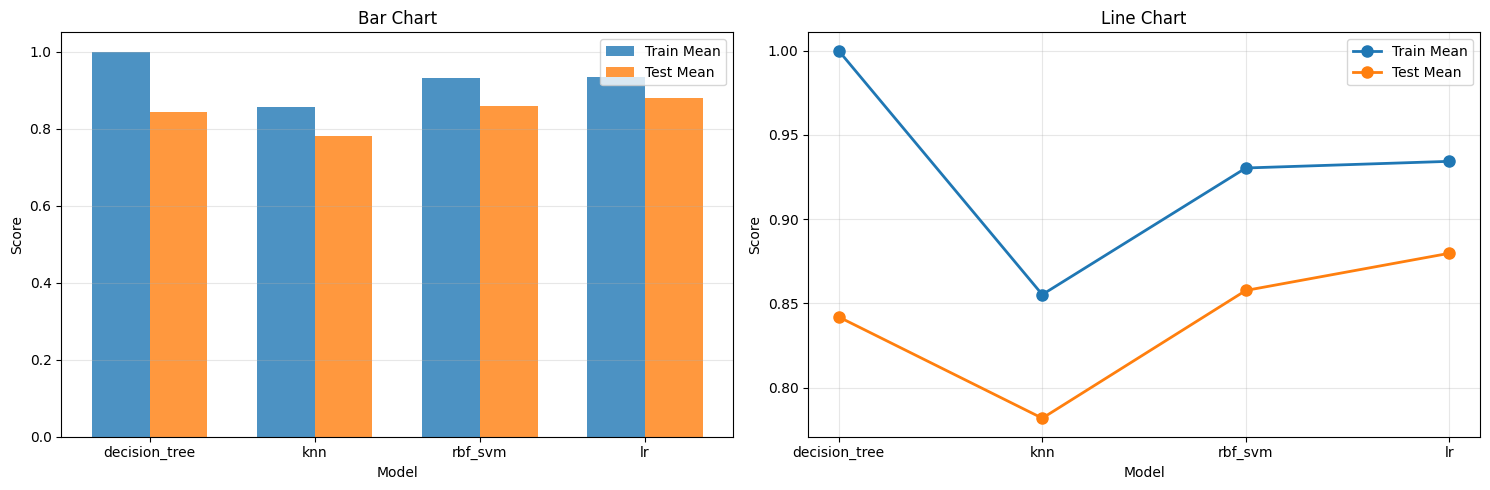

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
x = range(len(results_df))
width = 0.35
ax1.bar([i - width/2 for i in x], results_df['train_mean'], width, label='Train Mean', alpha=0.8)
ax1.bar([i + width/2 for i in x], results_df['test_mean'], width, label='Test Mean', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Bar Chart')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df.index)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Line chart
ax2.plot(results_df.index, results_df['train_mean'], marker='o', linewidth=2, markersize=8, label='Train Mean')
ax2.plot(results_df.index, results_df['test_mean'], marker='o', linewidth=2, markersize=8, label='Test Mean')
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_title('Line Chart')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [219]:
test_pipe = make_pipeline(preprocessor, LogisticRegression())

test_pipe.fit(X_train, y_train)
test_score = test_pipe.score(X_test, y_test)

In [220]:
test_score

0.9245283018867925

In [221]:
param_grid_dt = {
    "decisiontreeclassifier__max_depth": np.arange(3, 31)
}
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier())
grid_search_dt = GridSearchCV(pipe_dt, param_grid_dt, verbose=1, n_jobs=-1,) #grid search because small search space
grid_search_dt.fit(X_train, y_train)
pd.DataFrame(grid_search_dt.cv_results_)[["mean_test_score", "param_decisiontreeclassifier__max_depth", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


,mean_test_score,param_decisiontreeclassifier__max_depth,mean_fit_time
rank_test_score,,,
1,0.864087,28,0.011291
2,0.861012,7,0.014845
3,0.854613,6,0.017907
4,0.848462,9,0.013934
5,0.848363,17,0.012031
6,0.848264,30,0.012317
7,0.848214,26,0.010870
7,0.848214,22,0.011318
9,0.845238,15,0.010915


In [222]:
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": np.arange(3, 31) #grid search because small search space
}
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
grid_search_knn = GridSearchCV(pipe_knn, param_grid_knn, verbose=1, n_jobs=-1) #grid search because small search space
grid_search_knn.fit(X_train, y_train)
pd.DataFrame(grid_search_knn.cv_results_)[["mean_test_score", "param_kneighborsclassifier__n_neighbors", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


,mean_test_score,param_kneighborsclassifier__n_neighbors,mean_fit_time
rank_test_score,,,
1,0.807093,28,0.008835
1,0.807093,30,0.004956
3,0.807044,16,0.015514
3,0.807044,20,0.013012
3,0.807044,24,0.015455
6,0.803869,21,0.014468
6,0.803869,19,0.018496
6,0.803869,23,0.012741
9,0.803819,26,0.010442


In [223]:
param_grid_svc = {
    "svc__C": loguniform(1e-2, 1e3),
    "svc__gamma": loguniform(1e-4, 1e1)
}
pipe_svc = make_pipeline(preprocessor, SVC())
random_search_svc = RandomizedSearchCV(pipe_svc, param_grid_svc, n_iter=30, verbose=1, n_jobs=-1)
random_search_svc.fit(X_train, y_train)
pd.DataFrame(random_search_svc.cv_results_)[["mean_test_score", "param_svc__C", "param_svc__gamma", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,mean_test_score,param_svc__C,param_svc__gamma,mean_fit_time
rank_test_score,,,,
1,0.892510,14.265644,0.003163,0.007225
2,0.883135,37.629073,0.000114,0.008273
3,0.882937,617.184603,0.000214,0.006517
4,0.876736,6.006267,0.005053,0.006729
5,0.857738,1.002400,0.005666,0.006550
6,0.854613,15.854263,0.000101,0.006878
7,0.848313,4.664759,0.000348,0.007798
7,0.848313,2.217875,0.000742,0.014314
9,0.842014,30.892243,0.048432,0.017623


In [224]:
param_grid_lr = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}
pipe_lr = make_pipeline(preprocessor, LogisticRegression())
random_search_lr = RandomizedSearchCV(pipe_lr, param_grid_lr, n_iter=30, verbose=1, n_jobs=-1) 
random_search_lr.fit(X_train, y_train)
pd.DataFrame(random_search_lr.cv_results_)[["mean_test_score", "param_logisticregression__C", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,mean_test_score,param_logisticregression__C,mean_fit_time
rank_test_score,,,
1,0.895635,0.146297,0.013360
2,0.892510,0.075577,0.010215
3,0.889335,0.114588,0.008825
4,0.889236,0.233895,0.007342
4,0.889236,0.196541,0.017650
6,0.886062,0.270863,0.021920
7,0.883085,0.044836,0.007226
8,0.882887,0.838425,0.011755
8,0.882887,0.379911,0.014019


In [225]:
best_C = 0.066631

In [226]:
pipe_final = make_pipeline(preprocessor, LogisticRegression(C=best_C, max_iter=1000)) # best model based on hyperparameter optimization, max_iter=1000 to avoid warning
pipe_final.fit(X_train, y_train)
test_score_final = pipe_final.score(X_test, y_test)

In [227]:
test_score_final

0.9245283018867925

sometimes better than without hyp opt, sometimes worse... well within error bars, but a few points worse than cv... i mean lowk to be expected w/ small dataset 